In [1]:
# To ignore warnings

import os, warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the COVID-19 dataset mentioned in section 5.2

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Country/Region'] == 'US']
df.fillna(0, inplace=True)
# df = df[df['New_Cases'] >= 0]

In [4]:
# Feature engineering

df['New_Cases'] = df['Confirmed'].diff().fillna(0)

In [6]:
# Split the data into training and testing sets

start_date = pd.Timestamp('2020-03-01')
end_date = pd.Timestamp('2020-03-21')
df_train = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

test_start_date = pd.Timestamp('2020-03-22')
test_end_date = pd.Timestamp('2020-03-25')
df_test = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

In [8]:
# df_test

In [10]:
# Prepare the data for modeling mentioned in Section 5.2 (Univariate approach)

target = ['New_Cases']

train_data = df_train[target].values
test_data = df_test[target].values

In [11]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Only for prediction without any data standardization
# scaled_train_data = train_data
# scaled_test_data = test_data

In [16]:
# Function to create sequences of data for training and testing

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [25]:
# Create sequences for training and testing

seq_length = 1 # Number of days to look back
X_train, y_train = create_sequences(scaled_train_data, seq_length)
X_test, y_test = create_sequences(scaled_test_data, seq_length)

In [26]:
# Build and compile the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [27]:
# Train the model

model.fit(X_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
2/2 [==============================] - 4s 10ms/step - loss: 0.1365
Epoch 2/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1283
Epoch 3/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1198
Epoch 4/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1150
Epoch 5/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1092
Epoch 6/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1053
Epoch 7/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0989
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0954
Epoch 9/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0925
Epoch 10/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0888
Epoch 11/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0857
Epoch 12/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0843
Epoch 13/100
2/2 [==============================] - 0s 9

In [28]:
# Make predictions and inverse transform the results

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # only for standardized series
y_test = scaler.inverse_transform(y_test)

1/1 [==============================] - 1s 1s/step


In [29]:
predictions # display results

array([[10127.942],
       [12690.136],
       [12082.199]], dtype=float32)

In [30]:
# Evaluate the predictions

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'Root Mean Squared Error for LSTM: {rmse}')
print(f'Mean Absolute Percentage Error for LSTM: {mape}')


Root Mean Squared Error for LSTM: 1334.721899544532
Mean Absolute Percentage Error for LSTM: 0.09689155785112445


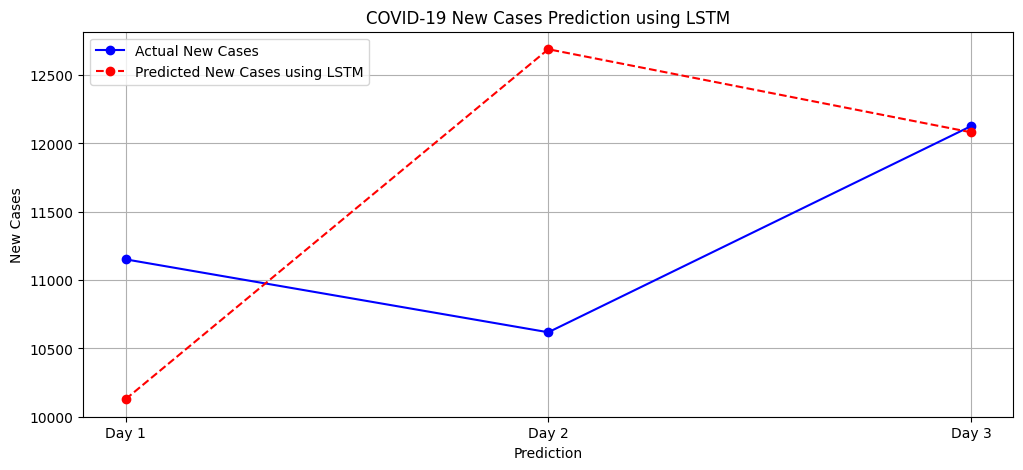

In [31]:
# Visualize the predictions as shown in Figure 5

days = ["Day 1", "Day 2", "Day 3"]
actual_new_cases = y_test
predicted_new_cases = predictions

plt.figure(figsize=(12, 5))
plt.plot(days, actual_new_cases, marker='o', linestyle='-', color='blue', label='Actual New Cases')
plt.plot(days, predicted_new_cases, marker='o', linestyle='--', color='red', label='Predicted New Cases using LSTM')

plt.title('COVID-19 New Cases Prediction using LSTM')
plt.xlabel('Prediction')
plt.ylabel('New Cases')
plt.legend()

plt.grid(True)
plt.show()

In [37]:
y_test

array([[11152.],
       [10618.],
       [12127.]])